In [125]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from scipy.stats import sem

# TCGA

In [126]:
# data source: https://xenabrowser.net/datapages/?dataset=Survival_SupplementalTable_S1_20171025_xena_sp&host=https%3A%2F%2Fpancanatlas.xenahubs.net&removeHub=https%3A%2F%2Fxena.treehouse.gi.ucsc.edu%3A443

file = 'TCGA/Survival_SupplementalTable_S1_20171025_xena_sp'
df = pd.read_csv(file, sep='\t')
df['race'] = df['race'].fillna('[Unknown]') # some entries has NaN as race...

tcga_cancer_sex_race = df.groupby(['cancer type abbreviation','gender','race']).agg({'_PATIENT':'nunique'}).reset_index()
tcga_cancer_sex_race.columns = ['Cancer','Sex','Race','Count']

# number of cancer types
lab = 'num of cancer types:'
x = len(set(df['cancer type abbreviation'].values))
print(' '.join([lab,str(x)]))

# average number of unique patients per cancer type
lab = 'average num patient per cancer type:'
x = df.groupby(['cancer type abbreviation']).agg({'_PATIENT':'nunique'}).mean()
print(' '.join([lab,str(x)]))

# average number of unique patients per cancer type per sex
lab = 'average num patient per cancer type per sex:'
x = df.groupby(['cancer type abbreviation','gender']).agg({'_PATIENT':'nunique'}).groupby(['gender']).agg({'_PATIENT':'mean'})
print(' '.join([lab,str(x)]))

# average number of unique patients per cancer type per race
lab = 'average num patient per cancer type per sex per race:'
x = df.groupby(['cancer type abbreviation','gender','race']).agg({'_PATIENT':'nunique'}).groupby(['gender','race']).agg({'_PATIENT':'mean'})
print(' '.join([lab,str(x)]))

num of cancer types: 33
average num patient per cancer type: _PATIENT    335.787879
dtype: float64
average num patient per cancer type per sex:           _PATIENT
gender            
FEMALE  186.322581
MALE    182.931034
average num patient per cancer type per sex per race:                                                     _PATIENT
gender race                                                 
FEMALE AMERICAN INDIAN OR ALASKA NATIVE             2.714286
       ASIAN                                       10.964286
       BLACK OR AFRICAN AMERICAN                   21.172414
       NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER    4.000000
       WHITE                                      139.129032
       [Not Evaluated]                              3.944444
       [Unknown]                                   19.130435
MALE   AMERICAN INDIAN OR ALASKA NATIVE             1.600000
       ASIAN                                       14.640000
       BLACK OR AFRICAN AMERICAN                   13.4

In [127]:
# Mesothelioma example

#lab = 'average num patient per cancer type and tumor stage per sex per race:'
#a = df.groupby(['cancer type abbreviation','ajcc_pathologic_tumor_stage','gender','race']).agg({'_PATIENT':'nunique'})
#display(HTML(a.to_html()))

df[df['cancer type abbreviation']=='MESO'].groupby(['gender','race']).agg({'_PATIENT':'nunique'})

_PATIENT
gender race                               
FEMALE BLACK OR AFRICAN AMERICAN         1
       WHITE                            15
MALE   ASIAN                             1
       WHITE                            70

# CEDCD

In [128]:
# source of data: https://cedcd.nci.nih.gov/cancer

xlsx_file = 'CEDCD/cancer_20200921.xlsx'
sheet_name = 'Cancer_Counts'
df = pd.read_excel(xlsx_file, sheet_name=sheet_name, skiprows=5)

studies = df.columns[2:]

lst = []
for i in df.groupby(['Cancer','Gender']):
    cancer = i[1].values[0][0]
    sex = i[1].values[0][1]
    for study in studies:
        lst.append([study,cancer,sex,i[1][study].values[0]])

df = pd.DataFrame.from_records(lst)
df.columns = ['Study','Cancer','Sex','Count']
df = df[pd.to_numeric(df['Count'], errors='coerce').notnull()]
cedcd_cancer_sex = df

# number of cancer types
lab = 'num of cancer types:'
x = len(set(df['Cancer'].values))
print(' '.join([lab,str(x)]))

# average number of unique patients per cohort
lab = 'average num patient per cohort:'
x = df.groupby(['Study']).agg({'Count':'sum'}).mean()
print(' '.join([lab,str(x)]))

# average number of unique patients per cohort, cancer type and sex
lab = 'average num patient per cohort, cancer type and sex:'
x = df.groupby(['Study','Cancer','Sex']).agg({'Count':'sum'}).groupby(['Sex']).mean()
print(' '.join([lab,str(x)]))

# average number of unique patients per cohort, race and sex
xlsx_file = 'CEDCD/enrollment_male_20200921.xlsx'
sheet_name = 'Enrollment_Counts'
df_male = pd.read_excel(xlsx_file, sheet_name=sheet_name, skiprows=6).drop(columns=['total'])
df_male['Sex'] = 'MALE'

xlsx_file = 'CEDCD/enrollment_female_20200921.xlsx'
sheet_name = 'Enrollment_Counts'
df_female = pd.read_excel(xlsx_file, sheet_name=sheet_name, skiprows=6).drop(columns=['total'])
df_female['Sex'] = 'FEMALE'

df = pd.concat([df_male,df_female])

studies = df.columns[2:len(df.columns)-1]

lst = []
for i in df.groupby(['Race','Sex']):
    race = i[1].values[0][1]
    sex = i[1].values[0][len(i[1].values[0])-1]
    for study in studies:
        count = [x for x in list(i[1][study].values) if not isinstance(x,str)]
        lst.append([study,race,sex,sum(count)])

df = pd.DataFrame.from_records(lst)
df.columns = ['Study','Race','Sex','Count']

lab = 'average num patient per cohort, race and sex:'
x = df.groupby(['Race','Sex']).agg({'Count':'mean'})
print(' '.join([lab,str(x)]))
cedcd_race_sex = df

num of cancer types: 25
average num patient per cohort: Count    14624.655172
dtype: float64
average num patient per cohort, cancer type and sex:              Count
Sex               
Female  328.504958
Male    279.753275
average num patient per cohort, race and sex:                                                          Count
Race                                      Sex                 
American Indian / Alaska Native           FEMALE    690.295082
                                          MALE       65.409836
Asian                                     FEMALE   6058.081967
                                          MALE     3420.393443
Black or African-American                 FEMALE   5446.147541
                                          MALE     1330.836066
More than one race                        FEMALE    439.803279
                                          MALE       64.229508
Native Hawaiian or Other Pacific Islander FEMALE    178.377049
                                       

# Plots

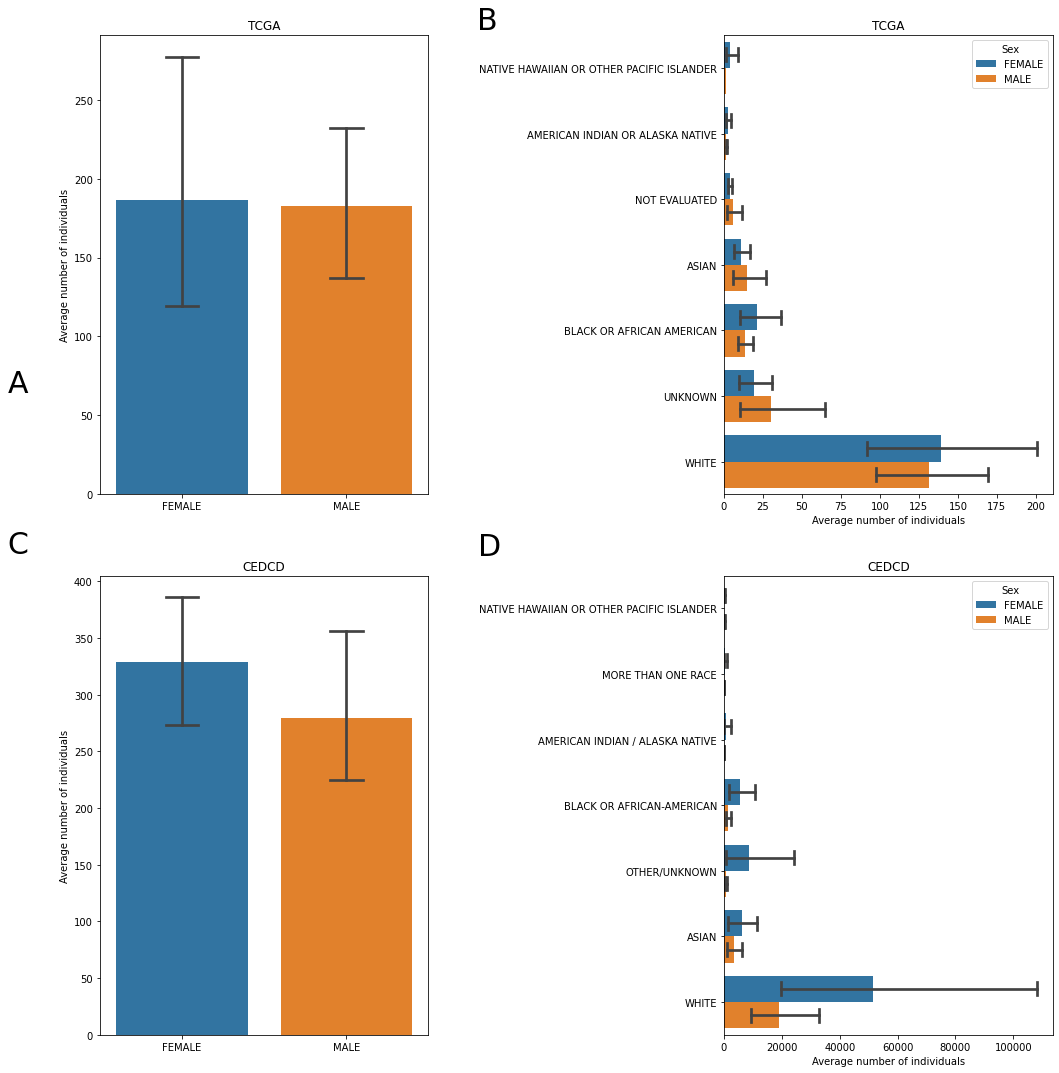

In [129]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(15,15))

tcga_cancer_sex_race['Race'] = tcga_cancer_sex_race['Race'].str.replace('[', '').str.replace(']', '').str.upper() 

sns.barplot(x="Sex", y="Count", data=tcga_cancer_sex_race.groupby(['Cancer','Sex']).agg({'Count':'sum'}).reset_index(),
            capsize=.2, ax=axs[0,0]).set_title('TCGA')
axs[0,0].set_xlabel('')
axs[0,0].set_ylabel('Average number of individuals')
axs[0,0].text(-1,65, "A", size=30, ha="center")

o = tcga_cancer_sex_race.groupby(['Race']).agg({'Count':sum}).reset_index().sort_values('Count')['Race']
sns.barplot(y="Race", x="Count", data=tcga_cancer_sex_race, capsize=.2,
            ax=axs[0,1], hue='Sex', order=o).set_title('TCGA')
#axs[0,1].tick_params('x', labelrotation=90) 
axs[0,1].set_ylabel('')
axs[0,1].set_xlabel('Average number of individuals')
axs[0,1].text(-152,-0.59, "B", size=30, ha="center")

cedcd_cancer_sex['Sex'] = cedcd_cancer_sex['Sex'].str.upper()
cedcd_race_sex['Race'] = cedcd_race_sex['Race'].str.upper()

sns.barplot(x="Sex", y="Count", data=cedcd_cancer_sex,
            capsize=.2, ax=axs[1,0]).set_title('CEDCD')
axs[1,0].set_xlabel('')
axs[1,0].set_ylabel('Average number of individuals')
axs[1,0].text(-1,425, "C", size=30, ha="center")

o = cedcd_race_sex.groupby(['Race']).agg({'Count':sum}).reset_index().sort_values('Count')['Race']
sns.barplot(y="Race", x="Count", data=cedcd_race_sex, capsize=.2,
            hue='Sex', ax=axs[1,1], order=o).set_title('CEDCD')
#axs[1,1].tick_params('x', labelrotation=90)
axs[1,1].set_ylabel('')
axs[1,1].set_xlabel('Average number of individuals')
axs[1,1].text(-81000,-0.809, "D", size=30, ha="center")

fig.tight_layout()

plt.savefig('demography_analysis.png')